In [1]:
import json
import os
from pathlib import Path
import time
import copy
import datetime
import collections
import random
import platform

import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from fastai.dataset import open_image
import json
from PIL import ImageDraw, ImageFont
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects
import cv2
from tqdm import tqdm

In [2]:
# params
SIZE = 224
EPOCHS = 5
BATCH_SIZE = 32
NUM_WORKERS = 4
SHOW_IMAGES = False

# static
IMAGES = 'images'
ANNOTATIONS = 'annotations'
CATEGORIES = 'categories'
ID = 'id'
NAME = 'name'
IMAGE_ID = 'image_id'
BBOX = 'bbox'
CATEGORY_ID = 'category_id'
FILE_NAME = 'file_name'
IMAGE = 'image'
CATEGORY = 'category'
TRAIN = 'train'
VAL = 'val'
TEST = 'test'

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = 'cpu'
print('device:', device)

device: cpu


Adjust data dir path for Paperspace or Kaggle

In [4]:
home_dir = os.path.expanduser('~')

if platform.system() == 'Darwin': # MAC
    DATA_DIR = '/Users/aaron/data/VOC2007/trainval/VOCdevkit/VOC2007/'
elif home_dir == '/home/paperspace':
    DATA_DIR = '/home/paperspace/data/pascal'
else: # kaggle
    DATA_DIR = '../input/pascal/pascal'

In [5]:
PATH = Path(DATA_DIR)
list(PATH.iterdir())

[PosixPath('/Users/aaron/data/VOC2007/trainval/VOCdevkit/VOC2007/ImageSets'),
 PosixPath('/Users/aaron/data/VOC2007/trainval/VOCdevkit/VOC2007/pascal_val2007.json'),
 PosixPath('/Users/aaron/data/VOC2007/trainval/VOCdevkit/VOC2007/SegmentationClass'),
 PosixPath('/Users/aaron/data/VOC2007/trainval/VOCdevkit/VOC2007/pascal_test2007.json'),
 PosixPath('/Users/aaron/data/VOC2007/trainval/VOCdevkit/VOC2007/SegmentationObject'),
 PosixPath('/Users/aaron/data/VOC2007/trainval/VOCdevkit/VOC2007/Annotations'),
 PosixPath('/Users/aaron/data/VOC2007/trainval/VOCdevkit/VOC2007/JPEGImages'),
 PosixPath('/Users/aaron/data/VOC2007/trainval/VOCdevkit/VOC2007/pascal_train2007.json')]

In [6]:
train_data = json.load((PATH/'pascal_train2007.json').open())
val_data = json.load((PATH/'pascal_val2007.json').open())
test_data = json.load((PATH/'pascal_test2007.json').open())

print('train:', train_data.keys())
print('val:', val_data.keys())
print('test:', test_data.keys())

train: dict_keys(['images', 'type', 'annotations', 'categories'])
val: dict_keys(['images', 'type', 'annotations', 'categories'])
test: dict_keys(['images', 'type', 'annotations', 'categories'])


In [7]:
def preview_data(data):
    if isinstance(data, (list, tuple)):
        return data[0]
    elif isinstance(data, dict):
        return next(iter(data.items()))
    else:
        raise TypeError(f"Unsupported type: {type(data)}")

In [8]:
train_data.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [9]:
preview_data(train_data[ANNOTATIONS])

{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
 'area': 34104,
 'iscrowd': 0,
 'image_id': 12,
 'bbox': [155, 96, 196, 174],
 'category_id': 7,
 'id': 1,
 'ignore': 0}

In [10]:
preview_data(train_data[IMAGES])

{'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12}

In [11]:
categories = train_data[CATEGORIES]

NUM_CATEGORIES = len(categories)
print('category count:', NUM_CATEGORIES)

category count: 20


In [12]:
# all categories are the same
train_categories = {c[ID]:c[NAME] for c in train_data[CATEGORIES]}
val_categories = {c[ID]:c[NAME] for c in val_data[CATEGORIES]}
test_categories = {c[ID]:c[NAME] for c in test_data[CATEGORIES]}
assert train_categories == val_categories == test_categories

categories = train_categories
print(categories)

{1: 'aeroplane', 2: 'bicycle', 3: 'bird', 4: 'boat', 5: 'bottle', 6: 'bus', 7: 'car', 8: 'cat', 9: 'chair', 10: 'cow', 11: 'diningtable', 12: 'dog', 13: 'horse', 14: 'motorbike', 15: 'person', 16: 'pottedplant', 17: 'sheep', 18: 'sofa', 19: 'train', 20: 'tvmonitor'}


In [13]:
IMAGE_PATH = Path(PATH/'JPEGImages/')
list(IMAGE_PATH.iterdir())[:2]

[PosixPath('/Users/aaron/data/VOC2007/trainval/VOCdevkit/VOC2007/JPEGImages/003301.jpg'),
 PosixPath('/Users/aaron/data/VOC2007/trainval/VOCdevkit/VOC2007/JPEGImages/006279.jpg')]

Helper functions for setting up `pandas.DataFrame` fed to the torch `Dataset`

In [14]:
def get_filenames(data):
    filenames = {o[ID]:o[FILE_NAME] for o in data[IMAGES]}
    print('get_id_filename_dict')
    print('length:', len(filenames), 'next item:', next(iter(filenames.items())))
    return filenames

In [15]:
def get_image_ids(data):
    image_ids = [o[ID] for o in data[IMAGES]]
    print('get_image_ids')
    print('length:', len(image_ids), 'next item:', image_ids[0])
    return image_ids

In [16]:
def pascal_bb_hw(bb):
    return bb[2:]

bbox = train_data[ANNOTATIONS][0][BBOX]
pascal_bb_hw(bbox)

[196, 174]

In [17]:
def get_full_filenames(id_filename_dict):
    # Returns a list of 2 item tuples (image_id, image_full_path)
    print('get_full_filenames')
    ret = [(k, f'{IMAGE_PATH}/{v}') for k,v in id_filename_dict.items()]
    print(preview_data(ret))
    return ret

### Train data structs

In [18]:
train_filenames = get_filenames(train_data)
train_image_ids = get_image_ids(train_data)
train_full_filenames = get_full_filenames(train_filenames)

get_id_filename_dict
length: 2501 next item: (12, '000012.jpg')
get_image_ids
length: 2501 next item: 12
get_full_filenames
(12, '/Users/aaron/data/VOC2007/trainval/VOCdevkit/VOC2007/JPEGImages/000012.jpg')


### Val data structs

In [19]:
val_filenames = get_filenames(val_data)
val_image_ids = get_image_ids(val_data)
val_full_filenames = get_full_filenames(val_filenames)

get_id_filename_dict
length: 2510 next item: (5, '000005.jpg')
get_image_ids
length: 2510 next item: 5
get_full_filenames
(5, '/Users/aaron/data/VOC2007/trainval/VOCdevkit/VOC2007/JPEGImages/000005.jpg')


# Image helper functions

In [20]:
def show_img(im, figsize=None, ax=None):
    if not ax:
        fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_rect(ax, b, edgecolor='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=edgecolor, lw=2))
    draw_outline(patch, 4)
    
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

# Multi-box Labels

### New Annotations Data struct

In [21]:
def get_new_train_ann(image_ids, data):
    """
    Returns a rank 2 array [n, 5]. 5 items in 2nd dimen are 4 bbox cords, last is the category
    """
    all_ann = {image_id:[] for image_id in image_ids}
    for x in data[ANNOTATIONS]:
        image_id = x[IMAGE_ID]
        bbox = x[BBOX]
        cat = [x[CATEGORY_ID]] # this is an int normally
        ann = np.concatenate([bbox, cat])
        if len(all_ann[image_id]) == 0:
            all_ann[image_id] = np.array([ann])
        else:
            prev = all_ann[image_id]
            new = ann
            all_ann[image_id] = np.reshape(np.concatenate([new, np.reshape(prev, -1)]), (-1, 5))
    return all_ann
    
new_val_ann = get_new_train_ann(val_image_ids, val_data)
preview_data(new_val_ann)

(5, array([[276, 185,  36,  35,   9],
        [240, 193,  55, 106,   9],
        [  4, 243,  63, 131,   9],
        [164, 263,  89, 109,   9],
        [262, 210,  62, 129,   9]]))

### Orig Annotations Data struct

In [22]:
def get_image_annotations(data):
    # returns a dict of {image_id: [((bbox, cat), ...)]} 
    # 1 item per image. Can be multi bbox per image
    ann = collections.defaultdict(lambda:[])
    for x in data[ANNOTATIONS]:
        ann[x[IMAGE_ID]].append((x[BBOX], x[CATEGORY_ID]))
    return ann

train_ann = get_image_annotations(train_data)

In [23]:
preview_data(train_ann)

(12, [([155, 96, 196, 174], 7)])

### Random image with multi-box labels

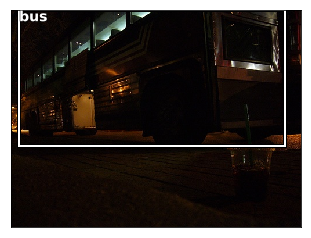

In [24]:
def show_random_multibox_image(ann, image_ids, filenames):
    image_id = random.choice(image_ids)
    im = open_image(str(IMAGE_PATH/filenames[image_id]))
    ax = show_img(im)
    for bbox, cat in ann[image_id]:
        draw_rect(ax, bbox)
        draw_text(ax, bbox[:2], categories[cat])

# TRAIN dataset example
show_random_multibox_image(train_ann, train_image_ids, train_filenames)

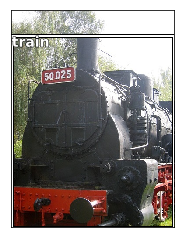

In [25]:
# new_train_ann version 

def new_show_random_multibox_image(ann, image_ids, filenames):
    image_id = random.choice(image_ids)
    im = open_image(str(IMAGE_PATH/filenames[image_id]))
    ax = show_img(im)
    for arr in ann[image_id]:
        bbox = arr[:4]
        cat = arr[-1]
        draw_rect(ax, bbox)
        draw_text(ax, bbox[:2], categories[cat])

# TRAIN dataset example
new_train_ann = get_new_train_ann(train_image_ids, train_data)

new_show_random_multibox_image(new_train_ann, train_image_ids, train_filenames)

In [26]:
val_ann = get_image_annotations(val_data)

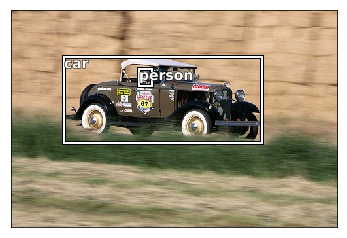

In [27]:
show_random_multibox_image(val_ann, val_image_ids, val_filenames)

Train Examples

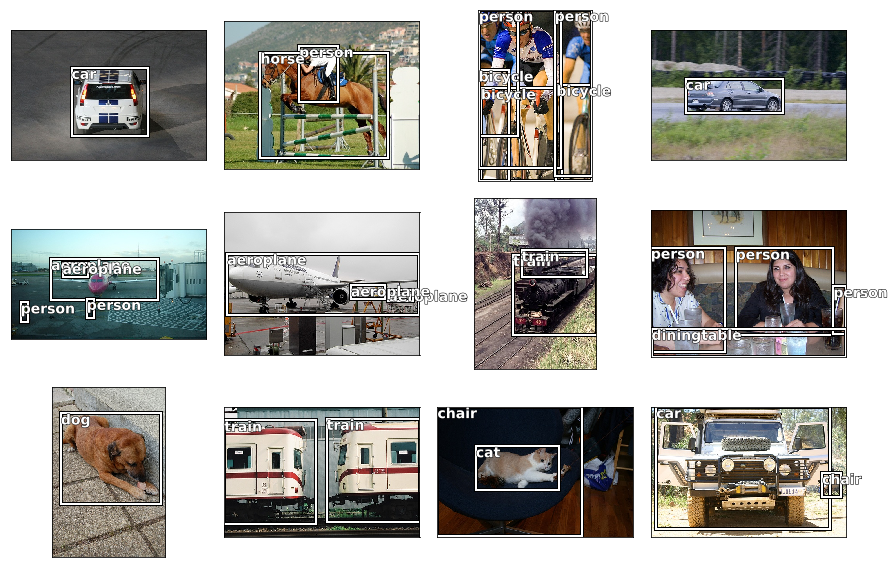

In [28]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    image_id = train_image_ids[i]
    image_anns = train_ann[image_id]
    im = open_image(str(IMAGE_PATH/train_filenames[image_id]))
    ax = show_img(im, ax=ax)
    for bbox, cat in image_anns:
        draw_rect(ax, bbox)
        draw_text(ax, bbox[:2], categories[cat])
plt.tight_layout()

VAL Examples

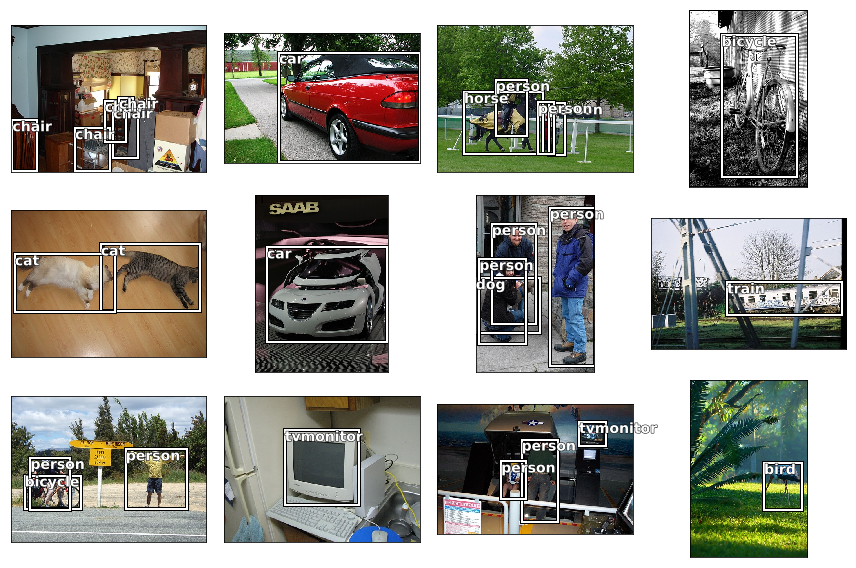

In [29]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    image_id = val_image_ids[i]
    image_anns = val_ann[image_id]
    im = open_image(str(IMAGE_PATH/val_filenames[image_id]))
    ax = show_img(im, ax=ax)
    for bbox, cat in image_anns:
        draw_rect(ax, bbox)
        draw_text(ax, bbox[:2], categories[cat])
plt.tight_layout()

# 4x4 Grid Model

In [30]:
anc_grid = 4
k = 1
anc_offset = 1/(anc_grid*2)
anc_offset

0.125

In [31]:
anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), 4)
anc_x

array([0.125, 0.125, 0.125, 0.125, 0.375, 0.375, 0.375, 0.375, 0.625, 0.625, 0.625, 0.625, 0.875, 0.875,
       0.875, 0.875])

In [32]:
anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), 4)
anc_y

array([0.125, 0.375, 0.625, 0.875, 0.125, 0.375, 0.625, 0.875, 0.125, 0.375, 0.625, 0.875, 0.125, 0.375,
       0.625, 0.875])

In [33]:
anc_centers = np.tile(np.stack([anc_x,anc_y], axis=1), (k,1))
anc_centers

array([[0.125, 0.125],
       [0.125, 0.375],
       [0.125, 0.625],
       [0.125, 0.875],
       [0.375, 0.125],
       [0.375, 0.375],
       [0.375, 0.625],
       [0.375, 0.875],
       [0.625, 0.125],
       [0.625, 0.375],
       [0.625, 0.625],
       [0.625, 0.875],
       [0.875, 0.125],
       [0.875, 0.375],
       [0.875, 0.625],
       [0.875, 0.875]])

In [34]:
anc_w = 1/anc_grid
anc_h = 1/anc_grid
anc_sizes = np.array([[anc_w, anc_h] for i in range(anc_grid*anc_grid)])
anc_sizes

array([[0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25]])

In [35]:
np.concatenate([anc_centers, anc_sizes], axis=1)

array([[0.125, 0.125, 0.25 , 0.25 ],
       [0.125, 0.375, 0.25 , 0.25 ],
       [0.125, 0.625, 0.25 , 0.25 ],
       [0.125, 0.875, 0.25 , 0.25 ],
       [0.375, 0.125, 0.25 , 0.25 ],
       [0.375, 0.375, 0.25 , 0.25 ],
       [0.375, 0.625, 0.25 , 0.25 ],
       [0.375, 0.875, 0.25 , 0.25 ],
       [0.625, 0.125, 0.25 , 0.25 ],
       [0.625, 0.375, 0.25 , 0.25 ],
       [0.625, 0.625, 0.25 , 0.25 ],
       [0.625, 0.875, 0.25 , 0.25 ],
       [0.875, 0.125, 0.25 , 0.25 ],
       [0.875, 0.375, 0.25 , 0.25 ],
       [0.875, 0.625, 0.25 , 0.25 ],
       [0.875, 0.875, 0.25 , 0.25 ]])

In [36]:
anchors = torch.tensor(np.concatenate([anc_centers, anc_sizes], axis=1), requires_grad=False, dtype=torch.float)
anchors

tensor([[0.1250, 0.1250, 0.2500, 0.2500],
        [0.1250, 0.3750, 0.2500, 0.2500],
        [0.1250, 0.6250, 0.2500, 0.2500],
        [0.1250, 0.8750, 0.2500, 0.2500],
        [0.3750, 0.1250, 0.2500, 0.2500],
        [0.3750, 0.3750, 0.2500, 0.2500],
        [0.3750, 0.6250, 0.2500, 0.2500],
        [0.3750, 0.8750, 0.2500, 0.2500],
        [0.6250, 0.1250, 0.2500, 0.2500],
        [0.6250, 0.3750, 0.2500, 0.2500],
        [0.6250, 0.6250, 0.2500, 0.2500],
        [0.6250, 0.8750, 0.2500, 0.2500],
        [0.8750, 0.1250, 0.2500, 0.2500],
        [0.8750, 0.3750, 0.2500, 0.2500],
        [0.8750, 0.6250, 0.2500, 0.2500],
        [0.8750, 0.8750, 0.2500, 0.2500]])

In [37]:
grid_sizes = torch.tensor(np.array([1/anc_grid]), requires_grad=False).unsqueeze(1)
grid_sizes

tensor([[0.2500]], dtype=torch.float64)

(0, 1)

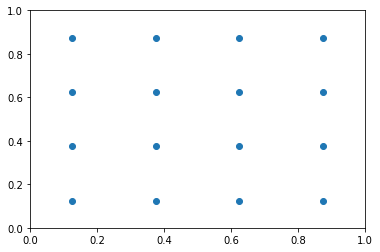

In [38]:
plt.scatter(anc_x, anc_y)
plt.xlim(0, 1)
plt.ylim(0, 1)

In [44]:
def hw2corners(center, hw):
    return torch.cat([center-hw/2, center+hw/2], dim=1)

# not in use, just for noting
centers = anchors[:,:2]
height_widths = anchors[:,2:]

anchor_corners = hw2corners(anchors[:,:2], anchors[:,2:])
anchor_corners

tensor([[0.0000, 0.0000, 0.2500, 0.2500],
        [0.0000, 0.2500, 0.2500, 0.5000],
        [0.0000, 0.5000, 0.2500, 0.7500],
        [0.0000, 0.7500, 0.2500, 1.0000],
        [0.2500, 0.0000, 0.5000, 0.2500],
        [0.2500, 0.2500, 0.5000, 0.5000],
        [0.2500, 0.5000, 0.5000, 0.7500],
        [0.2500, 0.7500, 0.5000, 1.0000],
        [0.5000, 0.0000, 0.7500, 0.2500],
        [0.5000, 0.2500, 0.7500, 0.5000],
        [0.5000, 0.5000, 0.7500, 0.7500],
        [0.5000, 0.7500, 0.7500, 1.0000],
        [0.7500, 0.0000, 1.0000, 0.2500],
        [0.7500, 0.2500, 1.0000, 0.5000],
        [0.7500, 0.5000, 1.0000, 0.7500],
        [0.7500, 0.7500, 1.0000, 1.0000]])

In [45]:
anchor_corners[7]

tensor([0.2500, 0.7500, 0.5000, 1.0000])

(0, 1)

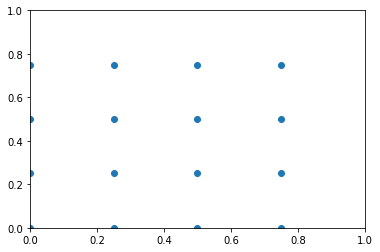

In [42]:
plt.scatter(anchor_corners[:,0], anchor_corners[:,1])
plt.xlim(0, 1)
plt.ylim(0, 1)

(0, 1)

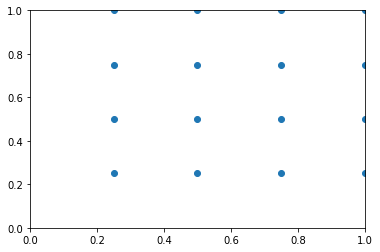

In [43]:
plt.scatter(anchor_corners[:,2], anchor_corners[:,3])
plt.xlim(0, 1)
plt.ylim(0, 1)

Calculate the `[0,1]` location for each object, in order to calculate the IoU

In [46]:
sample = preview_data(train_ann)
sample

(12, [([155, 96, 196, 174], 7)])

In [47]:
image_id, ann = sample

In [48]:
im = open_image(str(IMAGE_PATH/train_filenames[image_id]))
im.shape

(333, 500, 3)

In [49]:
im_h = im.shape[0]
im_w = im.shape[1]

In [50]:
scaled_ann = [(np.divide(bbox, [im_w, im_h, im_w, im_h]), cat) for bbox,cat in ann]
scaled_ann

[(array([0.31   , 0.28829, 0.392  , 0.52252]), 7)]

In [52]:
np.divide(im.shape, [im_h, im_w, 1])

array([1., 1., 3.])

Show the above Anchor Boxes data struct

In [53]:
def scale_pascal_bb(bbox, image, size):
    """
    Returns a bbox scaled to the target `size`
    
    Args:
        bbox (1d array): pascal_bb [x, y, x2, y2]
        image (3d array): HWC
        size (scalar): target image size that bbox should be scaled to
    """
    im_w = image.shape[1]
    im_h = image.shape[0]
    return np.multiply(np.divide(bbox, [im_w, im_h, im_w, im_h]), size)

(364, 480, 3)


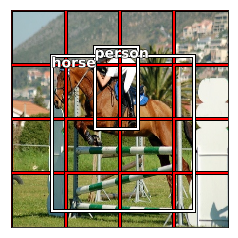

In [54]:
# image_id = random.choice(train_image_ids)
image_id = train_image_ids[1]
im = open_image(str(IMAGE_PATH/train_filenames[image_id]))
print(im.shape)
resized_image = cv2.resize(im, (SIZE, SIZE)) # HW
ax = show_img(resized_image)
for bbox in anchor_corners:
    draw_rect(ax, bbox*224, edgecolor='red')
for bbox, cat in train_ann[image_id]:
    bbox = scale_pascal_bb(bbox, im, SIZE)
    draw_rect(ax, bbox)
    draw_text(ax, bbox[:2], categories[cat])

In [55]:
# IoU for above image
image_id = train_image_ids[1]
im = open_image(str(IMAGE_PATH/train_filenames[image_id]))

bbox1, bbox2 = [scale_pascal_bb(bbox, im, SIZE) for bbox,cat in train_ann[image_id]]
bbox1, bbox2

(array([85.86667, 37.53846, 44.33333, 84.92308]),
 array([ 41.53333,  47.38462, 146.53333, 159.38462]))

In [56]:
# calc area for 'person'
bbox = bbox2
y1 = bbox[1]
x1 = bbox[0]
y2 = bbox[1] + bbox[3] - 1
x2 = bbox[0] + bbox[2] - 1
(x2-x1)*(y2-y1)

23050.241025641026

In [57]:
def fastai_bbs(bbs):
    return np.array([[bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1] for bb in bbs])

bbs = [scale_pascal_bb(bbox, im, SIZE) for bbox,cat in train_ann[image_id]]

fastai_bbs(bbs)

array([[ 37.53846,  85.86667, 121.46154, 129.2    ],
       [ 47.38462,  41.53333, 205.76923, 187.06667]])

In [58]:
def fastai_bb(bb):
    return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])

bb = fastai_bb(bbox2)
bb

array([ 47.38462,  41.53333, 205.76923, 187.06667])

In [59]:
y1, x1, y2, x2 = bb
(x2-x1)*(y2-y1)

23050.241025641026

In [60]:
# horse area
bbox = bbox2
print(bbox)
y1 = bbox[1]
x1 = bbox[0]
y2 = bbox[1] + bbox[3]
x2 = bbox[0] + bbox[2]
(x2-x1)*(y2-y1)

[ 41.53333  47.38462 146.53333 159.38462]


23355.158974358976

In [61]:
SIZE**2

50176

In [62]:
ab_224 = anchor_corners*SIZE
ab224 = ab_224
y1 = ab_224[:,0]
x1 = ab_224[:,1]
y2 = ab_224[:,2]
x2 = ab_224[:,3]
ab_area = (x2-x1)*(y2-y1)
ab_area

tensor([3136., 3136., 3136., 3136., 3136., 3136., 3136., 3136., 3136., 3136.,
        3136., 3136., 3136., 3136., 3136., 3136.])

In [63]:
bb

array([ 47.38462,  41.53333, 205.76923, 187.06667])

In [64]:
single_ab_area = 56**2.
single_ab_area

3136.0

In [65]:
y1, x1, y2, x2 = bb
bb_area = (x2-x1)*(y2-y1)
bb_area

23050.241025641026

In [66]:
union = single_ab_area + bb_area
union

26186.241025641026

In [67]:
# calc intersection
# bb[:2]
bb16 = np.reshape(np.tile(bb, ab224.shape[0]), (-1, 4))
bb16.shape

(16, 4)

In [68]:
ab224.shape

torch.Size([16, 4])

In [69]:
max_xy = np.maximum(ab224[:,:2], bb16[:,:2])
max_xy.shape

torch.Size([16, 2])

In [70]:
min_xy = np.minimum(ab224[:,2:], bb16[:,2:])
min_xy.shape

torch.Size([16, 2])

In [71]:
intersect = np.abs(max_xy - min_xy)
intersect.shape

torch.Size([16, 2])

In [72]:
sinble_bb_iou = intersect[:,0] * intersect[:,1]
sinble_bb_iou

tensor([ 124.6359,  482.4615,  482.4615,  164.2667,  810.1333, 3136.0000,
        3136.0000, 1067.7333,  810.1333, 3136.0000, 3136.0000, 1067.7333,
         546.3949, 2115.0769, 2115.0769,  720.1333], dtype=torch.float64)

In [73]:
8.61538 * 14.46667

124.63585938460001

## Intersection part of IoU for a single bbox

In [74]:
# calculate `intersect` in a single function
def get_intersect(bbox, anchor_corners):
    bb = fastai_bb(bbox)
    ab224 = anchor_corners*SIZE
    bb16 = np.reshape(np.tile(bb, ab224.shape[0]), (-1, 4))
    max_xy = np.maximum(ab224[:,:2], bb16[:,:2])
    min_xy = np.minimum(ab224[:,2:], bb16[:,2:])
    intersect = np.abs(max_xy - min_xy)
    return intersect[:,0] * intersect[:,1]

get_intersect(bbox2, anchor_corners)

tensor([ 124.6359,  482.4615,  482.4615,  164.2667,  810.1333, 3136.0000,
        3136.0000, 1067.7333,  810.1333, 3136.0000, 3136.0000, 1067.7333,
         546.3949, 2115.0769, 2115.0769,  720.1333], dtype=torch.float64)

In [75]:
bboxes = [scale_pascal_bb(bbox, im, SIZE) for bbox,cat in train_ann[image_id]]
bbox = bboxes # [bbox2]
bb = [fastai_bb(bb) for bb in bbox]
ab224 = anchor_corners*SIZE
bb16 = np.reshape(np.tile(bb, ab224.shape[0]), (-1, 4))
# max_xy = np.maximum(ab224[:,:2], bb16[:,:2])
# min_xy = np.minimum(ab224[:,2:], bb16[:,2:])
# intersect = np.abs(max_xy - min_xy)
# bbox_intersect = intersect[:,0] * intersect[:,1]

In [76]:
bb16.shape

(32, 4)

In [77]:
bb16 = np.reshape(np.tile(bb, ab224.shape[0]), (len(bb), -1, 4))
bb16.shape

(2, 16, 4)

In [78]:
max_xy = np.maximum(ab224[:,:2], bb16[:,:,:2])
max_xy.shape

torch.Size([2, 16, 2])

In [79]:
min_xy = np.minimum(ab224[:,2:], bb16[:,:,2:])
min_xy.shape

torch.Size([2, 16, 2])

In [80]:
intersect = np.abs(max_xy - min_xy)
intersect.shape

torch.Size([2, 16, 2])

In [81]:
bbox_intersect = intersect[:,:,0] * intersect[:,:,1]
bbox_intersect.shape

torch.Size([2, 16])

In [99]:
bbox1, bbox2 = [scale_pascal_bb(bbox, im, SIZE) for bbox,cat in train_ann[image_id]]

np.reshape(np.concatenate(
    [get_intersect(bbox1, anchor_corners),
    get_intersect(bbox2, anchor_corners)]
), (2,-1)) == bbox_intersect

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=torch.uint8)

## Intersection part of IoU for N bboxes

In [96]:
# calculate all bbox intersections in a single function

def get_bb_intersect_single(bbox, anchor_corners):
    bb = [fastai_bb(bb) for bb in bbox]
    ab224 = anchor_corners*SIZE
    bb16 = np.reshape(np.tile(bb, ab224.shape[0]), (len(bb), -1, 4))
    max_xy = np.maximum(ab224[:,:2], bb16[:,:,:2])
    min_xy = np.minimum(ab224[:,2:], bb16[:,:,2:])
    intersect = np.abs(max_xy - min_xy)
    return intersect[:,:,0] * intersect[:,:,1]
    
bbox = [scale_pascal_bb(bbox, im, SIZE) for bbox,cat in train_ann[image_id]]

bbox_intersect2 = get_bb_intersect_single(bbox, anchor_corners)

bbox_intersect == bbox_intersect2

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=torch.uint8)

In [98]:
bbox_intersect2

tensor([[ 551.3846,  482.4615,  317.5385,  716.3077, 1672.5333, 1463.4667,
          963.2000, 2172.8000,  282.5846,  247.2615,  162.7385,  367.1077,
         1389.9487, 1216.2051,  800.4615, 1805.6923],
        [ 124.6359,  482.4615,  482.4615,  164.2667,  810.1333, 3136.0000,
         3136.0000, 1067.7333,  810.1333, 3136.0000, 3136.0000, 1067.7333,
          546.3949, 2115.0769, 2115.0769,  720.1333]], dtype=torch.float64)

In [100]:
# calculate IoU

In [101]:
bbox = [scale_pascal_bb(bbox, im, SIZE) for bbox,cat in train_ann[image_id]]
bbox

[array([85.86667, 37.53846, 44.33333, 84.92308]),
 array([ 41.53333,  47.38462, 146.53333, 159.38462])]

In [102]:
bb = bbox[0]
y1, x1, y2, x2 = bb
bb_area = np.abs((x2-x1)*(y2-y1))
bb_area

1968.0410256410264

In [103]:
bb = bbox[1]
y1, x1, y2, x2 = bb
bbox2_area = x2*y2
bbox2_area

23355.158974358976

In [104]:
total_area = SIZE**2.
total_area

50176.0

In [105]:
bb_area / total_area

0.039222756410256424

In [106]:
grid_sizes

tensor([[0.2500]], dtype=torch.float64)

In [107]:
single_ab_area = total_area / 16.
single_ab_area

3136.0

In [108]:
bbox2

array([ 41.53333,  47.38462, 146.53333, 159.38462])

In [109]:
intersect_bbox2 = get_intersect(bbox2, anchor_corners)
bbox2_iou = intersect_bbox2 / single_ab_area
bbox2_iou

tensor([0.0397, 0.1538, 0.1538, 0.0524, 0.2583, 1.0000, 1.0000, 0.3405, 0.2583,
        1.0000, 1.0000, 0.3405, 0.1742, 0.6745, 0.6745, 0.2296],
       dtype=torch.float64)

In [114]:
bbox2_iou_max, bbox2_max_idx = torch.max(bbox2_iou, dim=0)
bbox2_iou_max, bbox2_max_idx

(tensor(1., dtype=torch.float64), tensor(5))

In [115]:
bbox2_iou > .5

tensor([0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0], dtype=torch.uint8)

In [113]:
np.argwhere(bbox2_iou > .5)

tensor([[ 5,  6,  9, 10, 13, 14]])

In [125]:
bbox2_iou[bbox2_iou > .5]

tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.6745, 0.6745], dtype=torch.float64)

## Single Bbox IoU

In [124]:
def get_single_bbox_iou(bbox, anchor_corners):
    intersect_bbox = get_intersect(bbox, anchor_corners)
    bbox_iou = intersect_bbox / single_ab_area
    
    return bbox_iou[bbox_iou > .5], np.argwhere(bbox_iou > .5)

get_single_bbox_iou(bbox2, anchor_corners)

(tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.6745, 0.6745], dtype=torch.float64),
 tensor([[ 5,  6,  9, 10, 13, 14]]))

In [126]:
# IoU for multi-bbox

In [127]:
bbox = np.array(bbox)
bbox

array([[ 85.86667,  37.53846,  44.33333,  84.92308],
       [ 41.53333,  47.38462, 146.53333, 159.38462]])

In [128]:
bb = bbox[1]
y1, x1, y2, x2 = bb
bbox2_area = x2*y2
bbox2_area

23355.158974358976

In [129]:
bbox_areas = bbox[:,2] * bbox[:,3]
bbox_areas

array([ 3764.92308, 23355.15897])

In [130]:
bbox_intersect2.shape

torch.Size([2, 16])

In [131]:
torch.max(bbox_intersect2 / single_ab_area, dim=1)

(tensor([0.6929, 1.0000], dtype=torch.float64), tensor([7, 5]))

In [132]:
bbox_intersect2[0]

tensor([ 551.3846,  482.4615,  317.5385,  716.3077, 1672.5333, 1463.4667,
         963.2000, 2172.8000,  282.5846,  247.2615,  162.7385,  367.1077,
        1389.9487, 1216.2051,  800.4615, 1805.6923], dtype=torch.float64)

In [133]:
bbox2_bak = bbox2
bbox2 = bbox1
intersect_bbox2 = get_intersect(bbox2, anchor_corners)
bbox2_iou = intersect_bbox2 / single_ab_area
bbox2_iou

bbox2_iou_max, bbox2_max_idx = torch.max(bbox2_iou, dim=0)
bbox2_iou_max, bbox2_max_idx

(tensor(0.6929, dtype=torch.float64), tensor(7))

In [134]:
bbox2_iou

tensor([0.1758, 0.1538, 0.1013, 0.2284, 0.5333, 0.4667, 0.3071, 0.6929, 0.0901,
        0.0788, 0.0519, 0.1171, 0.4432, 0.3878, 0.2552, 0.5758],
       dtype=torch.float64)

In [135]:
intersect_bbox2

tensor([ 551.3846,  482.4615,  317.5385,  716.3077, 1672.5333, 1463.4667,
         963.2000, 2172.8000,  282.5846,  247.2615,  162.7385,  367.1077,
        1389.9487, 1216.2051,  800.4615, 1805.6923], dtype=torch.float64)

In [136]:
torch.max(intersect_bbox2, dim=0)

(tensor(2172.8000, dtype=torch.float64), tensor(7))

In [137]:
single_ab_area

3136.0

In [138]:
(SIZE**2.) / 16.

3136.0

In [139]:
anchor_corners

tensor([[0.0000, 0.0000, 0.2500, 0.2500],
        [0.0000, 0.2500, 0.2500, 0.5000],
        [0.0000, 0.5000, 0.2500, 0.7500],
        [0.0000, 0.7500, 0.2500, 1.0000],
        [0.2500, 0.0000, 0.5000, 0.2500],
        [0.2500, 0.2500, 0.5000, 0.5000],
        [0.2500, 0.5000, 0.5000, 0.7500],
        [0.2500, 0.7500, 0.5000, 1.0000],
        [0.5000, 0.0000, 0.7500, 0.2500],
        [0.5000, 0.2500, 0.7500, 0.5000],
        [0.5000, 0.5000, 0.7500, 0.7500],
        [0.5000, 0.7500, 0.7500, 1.0000],
        [0.7500, 0.0000, 1.0000, 0.2500],
        [0.7500, 0.2500, 1.0000, 0.5000],
        [0.7500, 0.5000, 1.0000, 0.7500],
        [0.7500, 0.7500, 1.0000, 1.0000]])

In [142]:
bbox1

array([85.86667, 37.53846, 44.33333, 84.92308])

In [175]:
anchor_corners[7]

tensor([0.2500, 0.7500, 0.5000, 1.0000])

In [179]:
# maybe wrong ....

# def fastai_to_pascal_bb(ab):
#     return np.array([ab[0], 1-ab[1], ab[2]-ab[0], ab[3]-ab[1]])

# print('fastai bb:', ab)
# print('pascal bb:', fastai_to_pascal_bb(ab))

fastai bb: [0.25 0.75 0.5  1.  ]
pascal bb: [0.25 0.25 0.25 0.25]


[56. 56. 56. 56.]


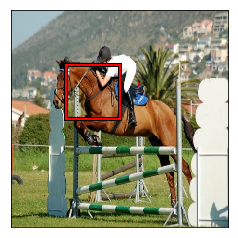

In [174]:
ab = anchor_corners[7].numpy()
bbox = np.array([ab[0], 1-ab[1], ab[2]-ab[0], ab[3]-ab[1]]) * SIZE
print(bbox)
ax = show_img(resized_image)
draw_rect(ax, bbox, edgecolor='red')

(364, 480, 3)


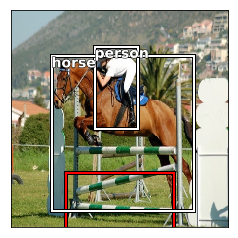

In [169]:
# image_id = random.choice(train_image_ids)
image_id = train_image_ids[1]
im = open_image(str(IMAGE_PATH/train_filenames[image_id]))
print(im.shape)
resized_image = cv2.resize(im, (SIZE, SIZE)) # HW
ax = show_img(resized_image)

# for bbox in anchor_corners:
bbox = anchor_corners[7]
draw_rect(ax, bbox*224, edgecolor='red')

for bbox, cat in train_ann[image_id]:
    bbox = scale_pascal_bb(bbox, im, SIZE)
    draw_rect(ax, bbox)
    draw_text(ax, bbox[:2], categories[cat])

# NEXT: calculate Multi Bbox IoU

In [172]:
categories[15]

'person'

## NEXT: calculate Jaccard overlap per Obj per Anchor Box

In [ ]:
actn_bbs = torch.tanh(anchor_corners)
actn_bbs 

In [ ]:
actn_centers = (actn_bbs[:,:2]/2 * grid_sizes.float()) + anchors[:,:2]
actn_centers

In [ ]:
actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
actn_hw

In [ ]:
hw2corners(actn_centers, actn_hw)

In [ ]:
def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes.float()) + anchors[:,:2]
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)

actn_corners = actn_to_bb(anchor_corners, anchors)
actn_corners

# Dataset

Scales image to (3, 224, 224) for Resnet18

Also scales the bbox

In [ ]:
class BboxDataset(Dataset):
    def __init__(self, full_filenames, data_ann):
        """
        Args:
            full_filenames (list): [(image_id, image_full_path), ...]
            data_bbox (dict): {image_id: (area, bbox, cat), ...}
        """
        self.full_filenames = full_filenames
        self.data_ann = data_ann

    def __len__(self):
        return len(self.full_filenames)
    
    def __getitem__(self, idx):
        image_id, image_path = self.full_filenames[idx]
        im = open_image(image_path) # HW
        resized_image = cv2.resize(im, (SIZE, SIZE)) # HW
        image = np.transpose(resized_image, (2, 0, 1)) # CHW
        
        bbox_cat = self.data_ann[image_id]

        im_w = im.shape[1]
        im_h = im.shape[0]
        scaled_bbox_cat = np.multiply(
            np.divide(bbox_cat, [im_w, im_h, im_w, im_h, 1]),
            [SIZE, SIZE, SIZE, SIZE, 1])

        return image_id, image, scaled_bbox_cat
    
dataset = BboxDataset(val_full_filenames, val_train_ann)
idx = 0
x = dataset[idx]
# image_id, inputs, bbox_count, bbox_label, cat_label = dataset[idx]
# image_id, inputs.shape, bbox_count, bbox_label, cat_label

In [ ]:
image_id, inputs, bbox_cat = x
image_id, inputs.shape, bbox_cat

In [ ]:
bbox_cat = preview_data(new_val_ann)
bbox_cat

In [ ]:
image_id, label = bbox_cat
label

In [ ]:
label[:,:4]

In [ ]:
idx = 0
image_id, image_path = val_full_filenames[idx]
image_id, image_path
# im = open_image(image_path)

In [ ]:
im = open_image(image_path)
im.shape

In [ ]:
label[:,:4]

In [ ]:
scaled_bbox = scale_pascal_bb(label[:,:4], im, SIZE)
scaled_bbox

In [ ]:
cats = label[:, -1:]
cats

In [ ]:
class BboxDataset(Dataset):
    def __init__(self, full_filenames, data_ann):
        """
        Args:
            full_filenames (list): [(image_id, image_full_path), ...]
            data_bbox (dict): {image_id: (area, bbox, cat), ...}
        """
        self.full_filenames = full_filenames
        self.data_ann = data_ann

    def __len__(self):
        return len(self.full_filenames)
    
    def __getitem__(self, idx):
        image_id, image_path = self.full_filenames[idx]
        im = open_image(image_path) # HW
        resized_image = cv2.resize(im, (SIZE, SIZE)) # HW
        image = np.transpose(resized_image, (2, 0, 1)) # CHW
        
        bbox_cat_list = self.data_ann[image_id]
        bbox = [bb[0] for bb in bbox_cat_list]
        cats = [bb[1] for bb in bbox_cat_list]
        scaled_bbox = scale_pascal_bb(bbox, im, SIZE)
        bbox_0_dimen = np.concatenate(scaled_bbox, -1)
        bbox_count = len(cats)

        return image_id, image, bbox_count, bbox_0_dimen, cats
    
dataset = BboxDataset(train_full_filenames, train_ann)
idx = 7
image_id, inputs, bbox_count, bbox_label, cat_label = dataset[idx]
image_id, inputs.shape, bbox_count, bbox_label, cat_label

In [ ]:
# idx = random.randint(0, 100)
idx = 7
image_id, inputs, bbox_count, bbox_0d_label, cat_label = dataset[idx]
image_id2, image_path = train_full_filenames[idx]
assert image_id == image_id2

im = open_image(str(image_path))
resized_image = cv2.resize(im, (SIZE, SIZE)) # HW
ax = show_img(resized_image)
bbox_labels = np.reshape(bbox_0d_label, (-1, 4))
for i in range(bbox_count):
    bbox = bbox_labels[i]
    cat = cat_labels[i]
    draw_rect(ax, bbox)
    draw_text(ax, bbox[:2], categories[cat])

# DataLoader

In [ ]:
BATCH_SIZE = 4
NUM_WORKERS = 0

def collate_fn(mini_batch):
    mini_batch_count = len(mini_batch)
    idx_image_id, idx_inputs, idx_bbox_count, idx_bbox_0d_label, idx_cat_label = range(5)
    
    image_ids = torch.tensor([mini_batch[i][0] for i in range(mini_batch_count)])
    inputs = torch.tensor([mini_batch[i][1] for i in range(mini_batch_count)], dtype=torch.float)
    import pdb;pdb.set_trace()
    bbox_labels = torch.tensor([mini_batch[i][2] for i in range(mini_batch_count)])
    cat_labels = torch.tensor([mini_batch[i][3] for i in range(mini_batch_count)])
    return image_ids, inputs, bbox_labels, cat_labels

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=NUM_WORKERS, collate_fn=collate_fn)

x = next(iter(dataloader))
# batch_image_ids, batch_inputs, batch_bbox_labels, batch_cat_labels = next(iter(dataloader))
# batch_image_ids, batch_inputs.size(), batch_bbox_labels, batch_cat_labels

In [ ]:
x = np.array([[  1.792  , 108.11733, 174.72   ,  87.21067],
       [ 72.576  ,  49.57867, 151.424  , 174.42133],
       [ 76.608  ,  74.66667,  67.2    , 127.82933],
       [  0.896  ,  80.04267,  56.896  , 102.144  ],
       [ 56.896  ,  50.176  ,  33.152  ,  48.384  ]])
x

In [ ]:
np.concatenate(x, -1)

In [ ]:
np.reshape(x, (-1, 4))

In [ ]:
np.reshape(x, (-1, 4)) == x

In [ ]:
image_id, inputs, bbox_labels, cat_labels = x

In [ ]:
image_id

In [ ]:
inputs.size()

In [ ]:
bbox_labels.size()

In [ ]:
cat_label

In [ ]:
len(x[0])

In [ ]:
image_id, inputs, labels = x[0]
image_id, inputs.shape, labels

In [ ]:
torch.tensor([a[0] for a in x])

### Val Dataset

val data structs

In [ ]:
val_filenames = get_filenames(val_data)
val_image_ids = get_image_ids(val_data)
val_full_filenames = get_full_filenames(val_filenames)

In [ ]:
val_full_filenames = get_full_filenames(val_filenames)
next(iter(val_full_filenames))

In [ ]:
val_image_w_bbox = get_image_w_bbox(val_data, val_image_ids)

In [ ]:
val_dataset = BboxDataset(val_full_filenames, val_image_w_bbox)

In [ ]:
preview_data(val_filenames)

In [ ]:
val_data[ANNOTATIONS][0]

In [ ]:
val_image_w_bbox = get_image_w_bbox(val_data, val_image_ids)
preview_data(val_image_w_bbox)

In [ ]:
print(preview_data(val_full_filenames))
print(preview_data(val_image_w_bbox))

In [ ]:
val_dataset = BboxDataset(val_full_filenames, val_image_w_bbox)
idx = 2
image_id, inputs, label = val_dataset[idx]
image_id, inputs.shape, label

In [ ]:
label

show Validation dataset image w/ bbox

In [ ]:
show_image_and_bbox(inputs, label)

Show the above image at **full scale** for the ground truth to see if it's correct

In [ ]:
idx = 2
image_id, filename = val_full_filenames[idx]
image_id, filename

In [ ]:
area, bbox, cat = val_image_w_bbox[image_id]
area, bbox, cat

In [ ]:
categories[cat]

In [ ]:
im = open_image(filename)
im.shape

In [ ]:
ax = show_img(im)
draw_rect(ax, bbox)
draw_text(ax, bbox[:2], categories[cat])

bbox helper functions

In [ ]:
def fastai_bb(bb):
    return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])

print(bbox)
print(fastai_bb(bbox))

In [ ]:
def pascal_bb_hw(bb):
    return bb[2:]

bbox = train_data[ANNOTATIONS][0][BBOX]
pascal_bb_hw(bbox)

# DataLoader

In [ ]:
BATCH_SIZE = 64
NUM_WORKERS = 0

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=NUM_WORKERS)

batch_image_ids, batch_inputs, batch_labels = next(iter(dataloader))

In [ ]:
batch_inputs.size()

In [ ]:
# batch_labels is a list, the first item is the "batch bbox's", 2nd item is "batch categories"

In [ ]:
len(batch_labels)

In [ ]:
batch_labels[0].size()

In [ ]:
batch_labels[1].size()

In [ ]:
# train the model

Val DataLoader

In [ ]:
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                            shuffle=True, num_workers=NUM_WORKERS)

Device check

In [ ]:
print('DEVICE:', device)

# Build model

In [ ]:
model_ft = models.resnet18(pretrained=True)

for layer in model_ft.parameters():
    layer.requires_grad = False
    
num_ftrs = model_ft.fc.in_features
IN_FEATURES = num_ftrs

print(IN_FEATURES, NUM_CATEGORIES)

# model_ft.fc = nn.Linear(num_ftrs, NUM_CATEGORIES)

# model_ft = model_ft.to(device)

# criterion = nn.CrossEntropyLoss()

# # Observe that all parameters are being optimized
# optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

# Custom head with single Layer fork to 2 outputs

`[bbox preds, category preds]`

In [ ]:
class BboxAndCatLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.cat_layer = nn.Linear(IN_FEATURES, NUM_CATEGORIES)
        self.bbox_layer = nn.Linear(IN_FEATURES, 4)
        
    def forward(self, x):
        return (self.bbox_layer(x), self.cat_layer(x), )
    
model_ft.fc = BboxAndCatLayer()

model_ft = model_ft.to(device)

### check Model output dimen

In [ ]:
image_ids, inputs, labels = next(iter(dataloader))

In [ ]:
print(len(labels))
print(type(labels))
print(labels[0].size())
print(labels[0].dtype)
print(labels[1].size())
print(labels[1].dtype)

In [ ]:
inputs = inputs.to(device)
outputs = model_ft(inputs)

In [ ]:
bbox_outputs, cat_outputs = outputs
bbox_outputs.size(), cat_outputs.size()

In [ ]:
_, cat_preds = torch.max(cat_outputs, dim=1)
cat_preds.size()

In [ ]:
preds = [bbox_outputs, cat_outputs]

print(preds[0].size())
print(preds[0].dtype)
print(preds[1].size())
print(preds[1].dtype)

# Loss Function - for custom head

In [ ]:
class BboxAndCatLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bbox_loss = nn.L1Loss()
        self.cat_loss = nn.CrossEntropyLoss()
        
    def forward(self, preds, targets):
        bbox_preds, cat_preds = preds
        bbox_targets, cat_targets = targets

        # data munging
        bbox_preds = bbox_preds.to(device, torch.float64)
        cat_targets_0_indexed = cat_targets - 1
        
        # per type of loss
        bbox_loss = self.bbox_loss(bbox_preds, bbox_targets)
        cat_loss = self.cat_loss(cat_preds, cat_targets_0_indexed)
        # cast b/c bbox_loss.dtype == torch.float64
        cat_loss = cat_loss.to(device, dtype=torch.float64)
        
        return bbox_loss + cat_loss
    
criterion = BboxAndCatLoss()

preds = [p.to(device) for p in preds]
labels = [x.to(device) for x in labels]

loss = criterion(preds, labels)
loss

# Train the model

In [ ]:
# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

In [ ]:
TRAIN = 'train'
VAL = 'val'

dataloaders = {
    TRAIN: dataloader,
    VAL: val_dataloader
}

dataset_sizes = {
    TRAIN: len(dataset),
    VAL: len(val_dataset)
}

In [ ]:
epoch_losses = {TRAIN: [], VAL: []}
epoch_accuracies = {TRAIN: [], VAL: []}

In [ ]:
best_model_weights = copy.deepcopy(model_ft.state_dict())
best_acc = 0.0

In [ ]:
# EPOCHS = 1

# for epoch in tqdm(range(EPOCHS)):
#     print('epoch:', epoch)
    
#     for phase in [TRAIN, VAL]:
#         running_loss = 0.0
#         running_correct = 0

#         for image_ids, inputs, labels in dataloaders[phase]:
#             inputs = inputs.to(device)

#             # labels - separate to.(device) b/c labels is a list
#             (bbox_labels, cat_labels) = labels
#             bbox_labels = bbox_labels.to(device)
#             cat_labels = cat_labels.to(device)

#             # clear gradients
#             optimizer.zero_grad()

#             # forward pass
#             outputs = model_ft(inputs)
#             bbox_outputs, cat_outputs = outputs
#             _, preds = torch.max(cat_outputs, dim=1)
#             loss = criterion(outputs, (bbox_labels, cat_labels))

#             # backwards pass
#             if phase == TRAIN:
#                 loss.backward()
#                 optimizer.step()

#             running_loss += loss.item() * inputs.size(0)
#             labels_0_indexed = cat_labels - 1
#             running_correct += torch.sum(preds == labels_0_indexed)

#         # per epoch/phase
#         epoch_loss = running_loss / dataset_sizes[phase]
#         epoch_acc = running_correct.double().item() / dataset_sizes[phase]
#         epoch_losses[phase].append(epoch_loss)
#         epoch_accuracies[phase].append(epoch_acc)

#     if epoch_accuracies[VAL][-1] > best_acc:
#         best_acc = epoch_accuracies[VAL][-1]
#         best_model_weights = copy.deepcopy(model_ft.state_dict())
        
#     print('train loss:', epoch_losses[TRAIN][-1], 'train acc:', epoch_accuracies[TRAIN][-1])
#     print('val loss:', epoch_losses[VAL][-1], 'val acc:', epoch_accuracies[VAL][-1])

Graph loss and accuracy

In [ ]:
epoch_losses

In [ ]:
epoch_accuracies

### check predictions

In [ ]:
plt.plot(epoch_losses['train'])
plt.plot(epoch_losses['val'])

In [ ]:
plt.plot(epoch_accuracies['train'])
plt.plot(epoch_accuracies['val'])

## save model weights

In [ ]:
MODEL_DIR = Path.cwd()/'data/model'
print(MODEL_DIR)
print('isdir:', os.path.isdir(MODEL_DIR))

In [ ]:
def maybe_create_model_dir():
    if not os.path.isdir(MODEL_DIR):
        os.mkdir(MODEL_DIR)

def save(state_dict):
    filepath = f'{MODEL_DIR}/model_{datetime.datetime.now().isoformat()}.pth'
    torch.save(state_dict, filepath)
    return filepath
    
maybe_create_model_dir()

filepath = save(model_ft.state_dict())
filepath

In [ ]:
def load(model, filepath):
    state_dict = torch.load(filepath)
    model.load_state_dict(state_dict)
    return model

model = load(model_ft, filepath)
model

## View predictions

In [ ]:
bbox_outputs, cat_outputs = outputs
_, preds = torch.max(cat_outputs, dim=1)
preds

predicted

In [ ]:
preds_count = len(preds)
fig, axes = plt.subplots(1, 7, figsize=(16, 16))
for i, ax in enumerate(axes.flat):
    im = np.transpose(inputs[i], (1, 2, 0))
    ax = show_img(im, ax=ax)
    draw_rect(ax, bbox_outputs[i])
    draw_text(ax, (0,0), categories[preds[i].item()+1])

Ground truth

In [ ]:
preds_count = len(preds)
fig, axes = plt.subplots(1, 7, figsize=(16, 16))
for i, ax in enumerate(axes.flat):
    im = np.transpose(inputs[i], (1, 2, 0))
    ax = show_img(im, ax=ax)
    draw_rect(ax, labels[0][i])
    draw_text(ax, (0,0), categories[labels[1][i].item()])